In [1]:
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
import sys
caffe_root = '/opt/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe

In [3]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_alexnnet/bvlc_alexnet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained AlexNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_alexnet

/bin/sh: 1: ../scripts/download_model_binary.py: not found


In [4]:
caffe.set_mode_gpu()

model_def = '/workspace/caffe/models/bvlc_alexnet/deploy.prototxt'
model_weights = '/workspace/caffe/models/bvlc_alexnet/bvlc_alexnet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
               caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [6]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

In [7]:
my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url
# transform it and copy it into the net
image = caffe.io.load_image('/workspace/image.jpeg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

--2019-11-15 22:34:38--  https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443340 (1.4M) [image/jpeg]
Saving to: 'image.jpg'

image.jpg           100%[===================>]   1.38M  --.-KB/s    in 0.08s   

2019-11-15 22:34:38 (16.2 MB/s) - 'image.jpg' saved [1443340/1443340]



/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


output label: n03063599 coffee mug
probabilities and labels:


[(0.57451552, 'n03063599 coffee mug'),
 (0.23812266, 'n07930864 cup'),
 (0.092601657, 'n07920052 espresso'),
 (0.04001265, 'n03775546 mixing bowl'),
 (0.016906882, 'n04263257 soup bowl')]

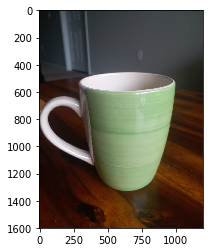

In [8]:
# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)
# load ImageNet labels
labels_file = '/workspace/caffe/data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]
print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])